# Задача 2. Сравнение методов классификации
## Божнюк Александр Сергеевич, группа 19.Б11

### Задача

- [ ] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [ ] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [ ] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [ ] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [ ] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [ ] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] * (**+2 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [726]:
# Необходимые импорты
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Реализация метода опорных векторов

In [727]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=10000, lmda=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.lmda = lmda


    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self._classes = unique_labels(y)
        self.X_ = X
        self.y_ = y
        for i in range(self.iter_num):
            self._update_weights()
        return self

    def _update_weights(self):
        n = self.X_.shape[1]
        self.w = np.zeros(n)
        self.b = 0
        y_label = np.where(self.y_ <= 0, -1, 1)
        for index, x_i in enumerate(self.X_):
            condition = y_label[index] * (np.dot(x_i, self.w) - self.b) >= 1
            if condition:
                dw = 2 * self.lmda * self.w
                db = 0
            else:
                dw = 2 * self.lmda * self.w - np.dot(x_i, y_label[index])
                db = y_label[index]
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lmda": self.lmda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Датасет

In [728]:
df = pd.read_csv('data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Описание датасета:

- age - age in years
- sex - (1 = male; 0 = female)
- cp - chest pain type
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholestoral in mg/dl
- fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results
- thalach - maximum heart rate achieved
- exang - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0-3) colored by flourosopy
- thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
- target - have disease or not (1=yes, 0=no)
Необходимо решить задачу классификации и научиться предсказывать целевой признак target имеет ли пациент заболевание сердца.

# EDA

In [729]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

Видим, что датасет сбалансирован, у целевого признака примерно одинаковое количество значений как для 1, так и для 0.
Можем отобразить это на диаграмме:

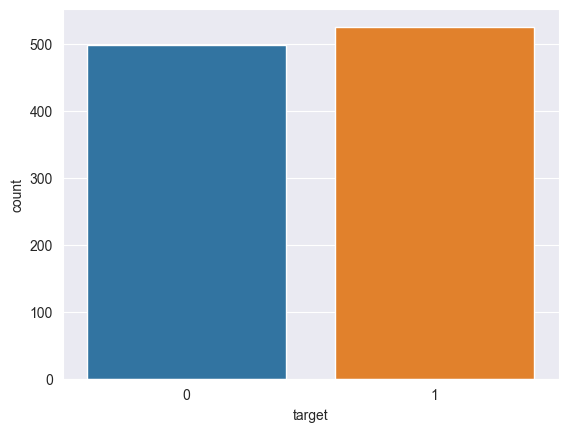

In [730]:
sns.countplot(x="target", data=df)
plt.show()

In [731]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Видим, что нет null значений, 13 признаков у нас целые, и 1 с плавающей точкой.

Посмотрим на диаграмму наличия сердечного признака в зависимости от возраста.

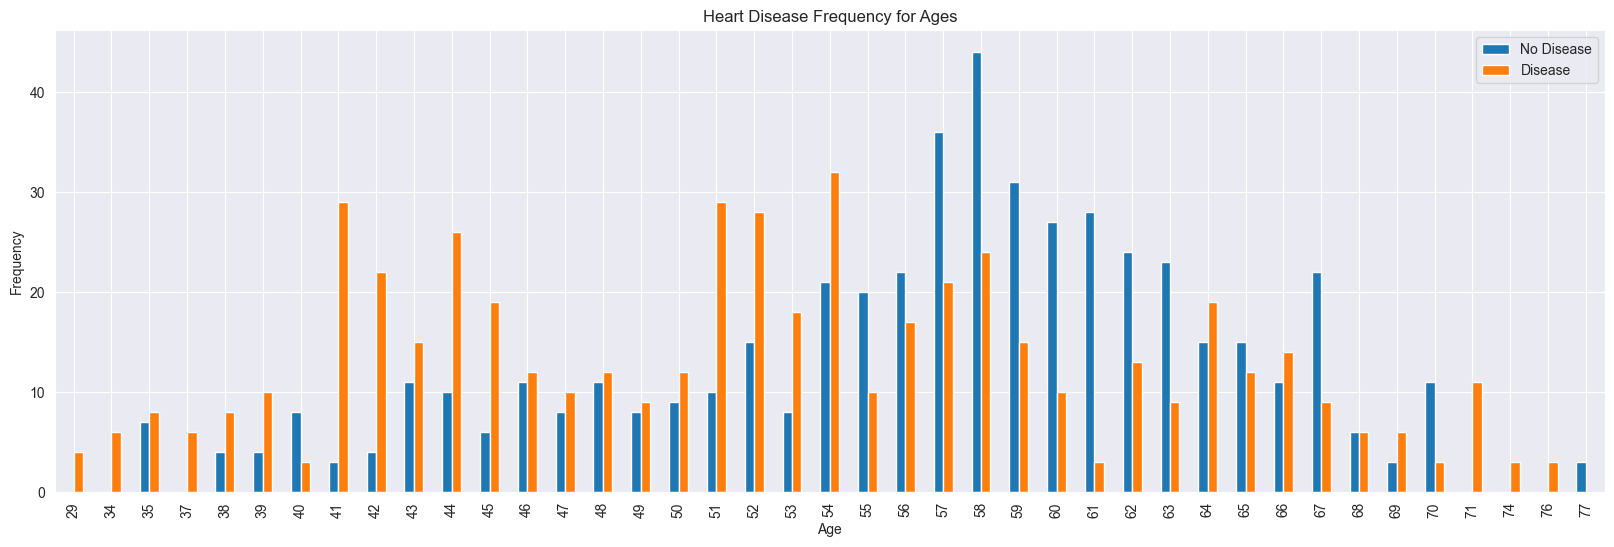

In [732]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No Disease", "Disease"])
plt.show()

Видим, что больше всего переживают приступы в возрасте от 41-45 и 51-54, в то время люди без приступов в большинстве своем находятся на промежутке от 55-63 лет.

Посмотрим на то, как меняется количество приступов в зависимости от возраста и уровня холестерина.

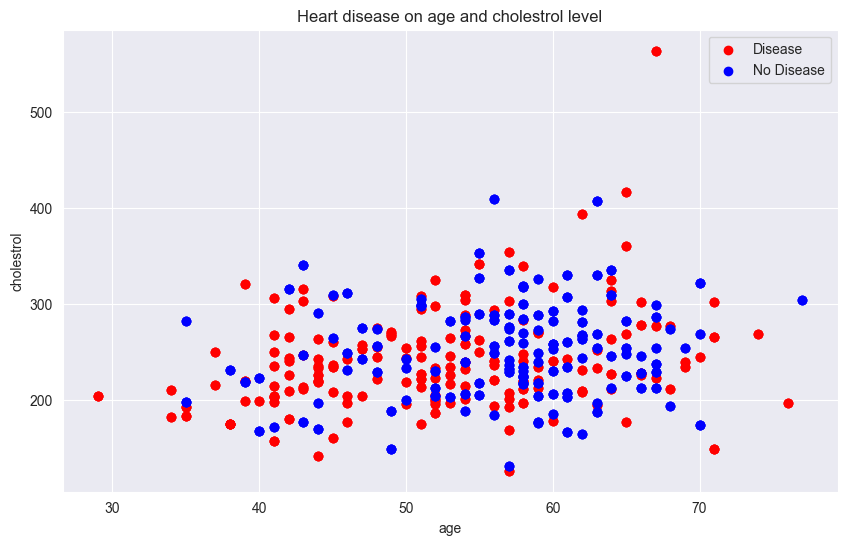

In [733]:
plt.figure(figsize = (10,6))

plt.scatter(df.age[df.target == 1],
            df.chol[df.target ==1],
            color = "red")

plt.scatter(df.age[df.target==0],
            df.chol[df.target==0],
            color = "blue")

plt.xlabel("age")
plt.ylabel("cholestrol")
plt.legend(["Disease", "No Disease"])
plt.title("Heart disease on age and cholestrol level")
plt.xticks(rotation = 0);

Видим, что люди от 41-45 и 51-54 имеют уровень холестерина меньше, чем у людей от 55-63 лет. У первых количество сердечных приступов меньше, чем у вторых.

Построим диаграмму количества сердечных приступов в зависимости от пола.

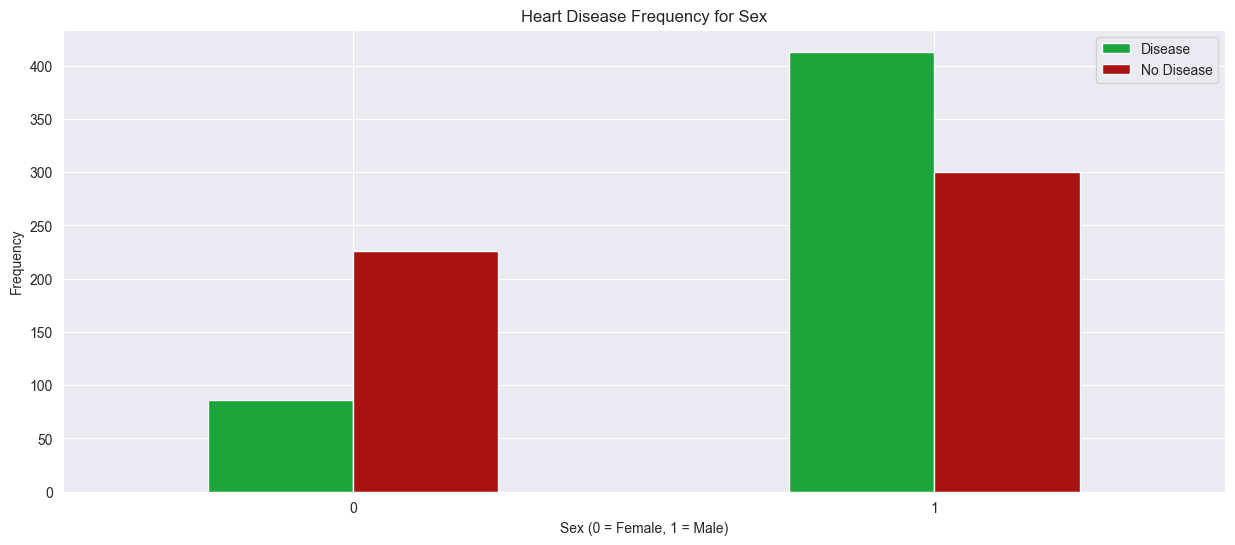

In [734]:
pd.crosstab(df.sex,df.target).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Disease", "No Disease"])
plt.ylabel('Frequency')
plt.show()

Видим, что в большинстве своем с сердечным приступом сталкиваются мужчины.

Посмотрим на то, как меняется количество приступов в зависимости от возраста и от максимальной частоты сердечных сокращений.

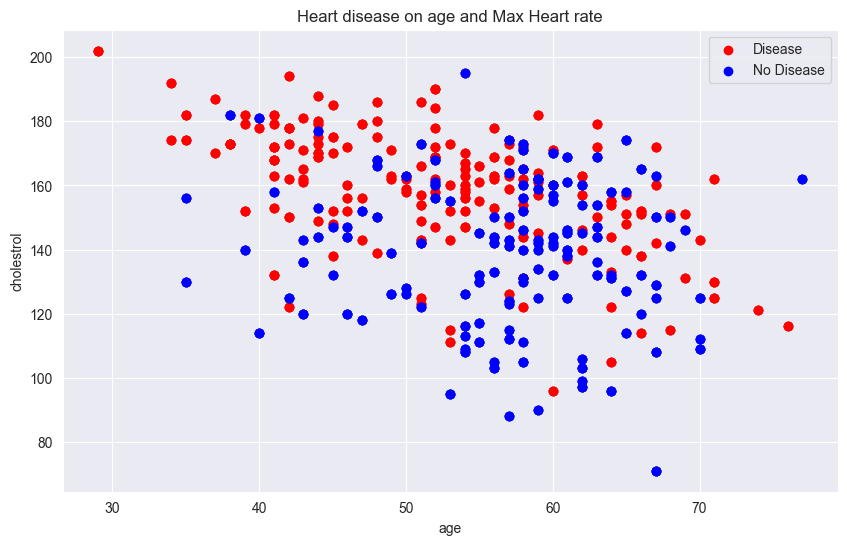

In [735]:
plt.figure(figsize = (10,6))

plt.scatter(df.age[df.target == 1],
            df.thalach[df.target ==1],
            color = "red")

plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            color = "blue")

plt.xlabel("age")
plt.ylabel("cholestrol")
plt.legend(["Disease", "No Disease"])
plt.title("Heart disease on age and Max Heart rate")
plt.xticks(rotation = 0);

Видим, что частота сокращений у людей проблемного возраста выше. У них же и наблюдается больше всего сердечных приступов. Напротив, у людей с меньшей частотой сокращений наблюдается меньше сердечных приступов, и они находятся как раз в том, возрасте, что мы наблюдали ранее.

Посмотрим на то, как меняется количество сердечных приступов в зависимости от типа боли в груди.

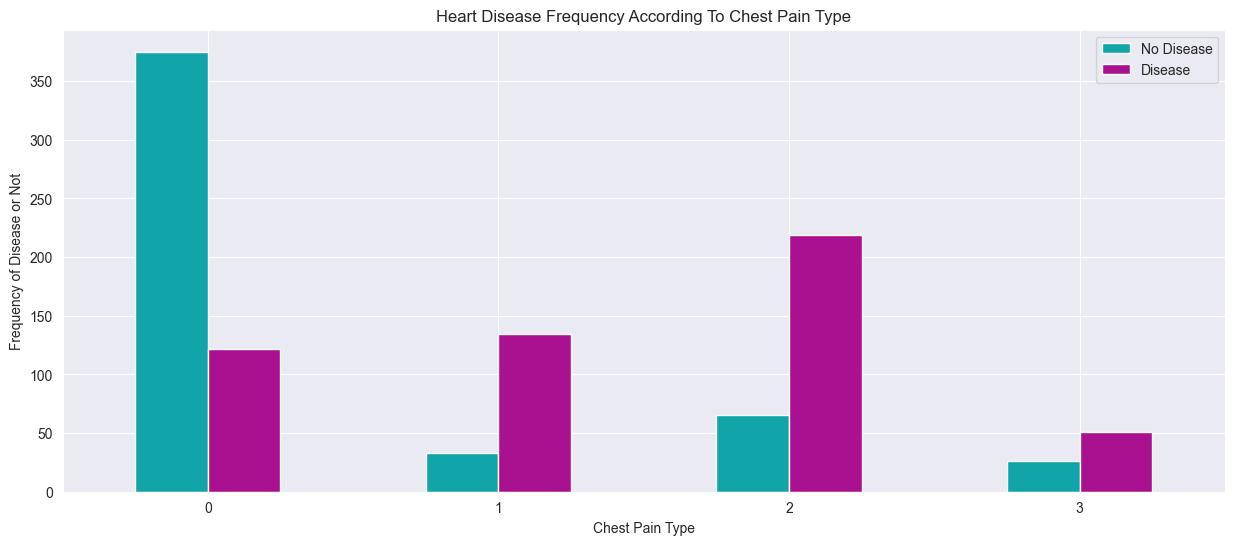

In [736]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15,6),color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Видно, что большинство пострадавших сталкивались с болью типа 2, меньше всего сталкивались с типом 3. Большинство избежавших приступа сталкивались с болью типа 0, а меньше всего - с типом 3.

Посмотрим на количество приступов в зависимости от пика физической нагрузки

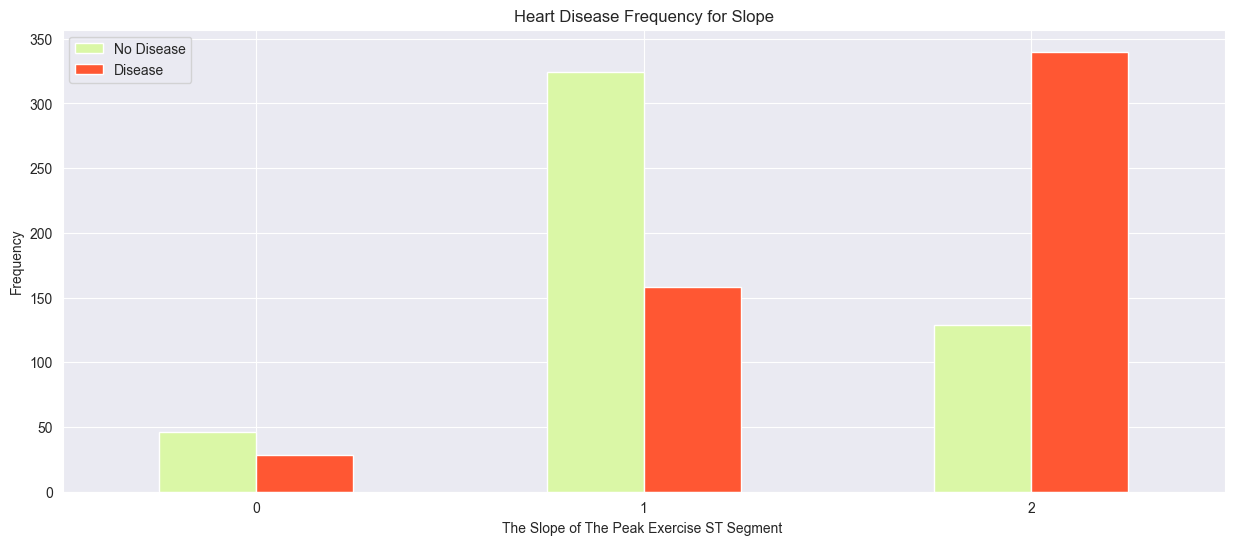

In [737]:
pd.crosstab(df.slope,df.target).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

Видим, что большинство пострадавших находятся в типе 2, а большинство переживших - в типе 1. В тип 0 не попало меньше всего людей.

Посмотрим на количество приступов в зависимости от количества сахара в крови во время голодания.

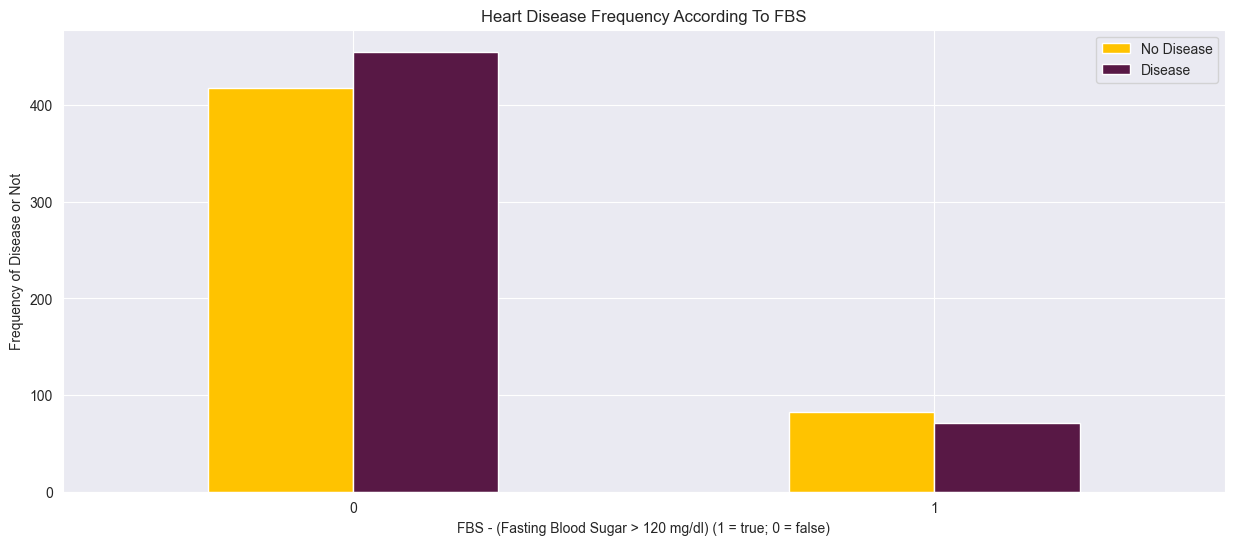

In [738]:
pd.crosstab(df.fbs,df.target).plot(kind="bar",figsize=(15,6),color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Видим, большинство людей, которые пережили приступ, имели пониженный сахар. Однако большинство людей в принципе (и среди тех, кто не пережл приступ) в выборке имели пониженный сахар.

Посмотрим на корреляцию признаков нашего датасета

<AxesSubplot: >

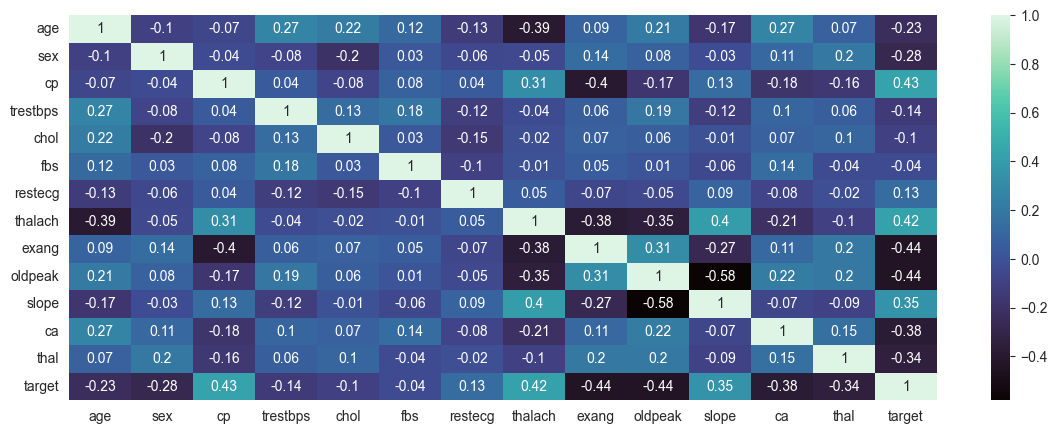

In [739]:
plt.figure(figsize = (14,5))
sns.heatmap(round(df.corr(),2),annot=True,cmap = 'mako')

Видно, что наибольшая корреляция признака target наблюдается с признаком slope, thalach и cp

# Feature Engineering

## Преобразование категориальных данных
Преобразуем категориальные признаки, закодировав их.

In [740]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0


## Разделение выборки

In [741]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Масштабирование

In [742]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)
x_train_scaled.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,-0.585840,0.654654,-0.779454,-1.935031,-0.414039,-0.983742,-1.019094,-0.725949,-0.210661,2.171691,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
1,1.051477,-1.527525,2.741732,1.610634,-0.414039,0.909846,0.202882,1.377507,-0.912152,-0.725467,...,-0.430083,-0.622478,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
2,-0.040068,-1.527525,-1.347387,0.442176,-0.414039,-0.983742,0.770228,-0.725949,-0.912152,-0.725467,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
3,0.505705,0.654654,0.186033,-0.222636,-0.414039,0.909846,0.508376,-0.725949,-0.473720,-0.725467,...,-0.430083,-0.622478,-0.293416,-0.049447,-0.26287,-1.070793,1.227862,-0.265511,1.042360,-0.913483
4,-0.367531,0.654654,-0.381900,-0.001032,2.415229,-0.983742,0.726586,-0.725949,1.192321,-0.725467,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,1.042360,-0.913483


## Подбор наилучших признаков

In [743]:
rfecv = RFECV(estimator=LogisticRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Выбранные признаки: ", selected_features)

Оптимальное число признаков:  17
Выбранные признаки:  ['sex', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_2', 'cp_3', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'slope_1', 'slope_2']


 Избавимся от ненужных признаков

In [744]:
x_train_scaled = x_train_scaled[selected_features]
x_test_scaled = x_test_scaled[selected_features]
x_train_scaled.head()

,sex,trestbps,chol,restecg,thalach,exang,oldpeak,ca,cp_0,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_1,slope_2
0,0.654654,-0.779454,-1.935031,-0.983742,-1.019094,-0.725949,-0.210661,2.171691,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
1,-1.527525,2.741732,1.610634,0.909846,0.202882,1.377507,-0.912152,-0.725467,1.029709,-0.622478,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
2,-1.527525,-1.347387,0.442176,-0.983742,0.770228,-0.725949,-0.912152,-0.725467,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
3,0.654654,0.186033,-0.222636,0.909846,0.508376,-0.725949,-0.473720,-0.725467,1.029709,-0.622478,-0.293416,-0.049447,-0.26287,-1.070793,1.227862,1.042360,-0.913483
4,0.654654,-0.381900,-0.001032,-0.983742,0.726586,-0.725949,1.192321,-0.725467,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,1.042360,-0.913483


# Метод опорных векторов

In [745]:
classifier = SVMClassifier(learning_rate=0.001, iter_num=10000, lmda=0.01)
classifier.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
y_test_prediction = classifier.predict(x_test_scaled)
training_data_accuracy = accuracy_score(y_test, y_test_prediction)
print("Test Accuracy of SVM Algorithm: {:.4f}".format(training_data_accuracy))

Test Accuracy of SVM Algorithm: 0.8146


# Тренировка библиотечных моделей

In [746]:
from sklearn.svm import SVC

svm = SVC(random_state = 12)
svm.fit(x_train_scaled, y_train)

acc = svm.score(x_test_scaled, y_test)
# accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.8537
